## Regime diagram

This notebook reproduces Figure 1 of [Li et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001810).
It plots the regime diagrams in parameter spaces La$_t$ - $h/L_L$ following [Belcher et al, 2012](https://doi.org/10.1029/2012GL052932) and the extension to stable surface forcing regime.

In particular, parameter space covered by JRA55-do forced GOTM runs is shown by the joint PDFs.
Overlaied are some representative LES studies of Langmuir turbulence.

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

### Functions

Auxiliary functions for plotting.

In [2]:
def loglog_hist2d(xdata, ydata, xpr, ypr):
    hist, xi, yi, c = plt.hist2d(xdata, ydata,
                                 range=(xpr, ypr), bins=100)
    # clean the figure
    plt.clf()
    # get the centers from the edges
    xi = 0.5*(xi[0:-1]+xi[1:])
    yi = 0.5*(yi[0:-1]+yi[1:])
    # convert back to actual values
    xi = 10**xi
    yi = 10**yi
    return hist, xi, yi

def plot_regime_diagram_background_BG12(axis=None):
    """Plot the background of the regime diagram
       following Fig. 3 of Belcher et al., 2012

    :axis: (matplotlib.axes, optional) axis to plot figure on

    """
    if axis is None:
        axis = plt.gca()

    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr] 
    ylims = [10**i for i in ypr] 
    # size of x and y
    nx = 500
    ny = 500
    xx = np.logspace(xpr[0], xpr[1], nx)
    yy = np.logspace(ypr[0], ypr[1], ny)
    zz1 = np.zeros([nx, ny]) 
    zz2 = np.zeros([nx, ny]) 
    zz3 = np.zeros([nx, ny]) 
    for i in np.arange(nx):
        for j in np.arange(ny):
            zz1[i,j] = 2*(1-np.exp(-0.5*xx[i]))
            zz2[i,j] = 0.22*xx[i]**(-2)
            zz3[i,j] = 0.3*xx[i]**(-2)*yy[j]
    zz = zz1 + zz2 + zz3
    axis.contourf(xx, yy, np.transpose(np.log10(zz)),
                  levels=[-0.1, 0, 0.1, 0.25, 0.5, 1, 2, 3, 4],
                  cmap='summer', extend='both')
    axis.contour(xx, yy, np.transpose(np.log10(zz)),
                  levels=[-0.1, 0, 0.1, 0.25, 0.5, 1, 2, 3, 4],
                  colors='darkgray')
    axis.contour(xx, yy, np.transpose(zz1/zz), levels=[0.9], colors='k',
                linestyles='-', linewidths=2)
    axis.contour(xx, yy, np.transpose(zz2/zz), levels=[0.9], colors='k',
                linestyles='-', linewidths=2)
    axis.contour(xx, yy, np.transpose(zz3/zz), levels=[0.9], colors='k',
                linestyles='-', linewidths=2)
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel('La$_t$')
    axis.set_ylabel('$h/L_L$')
    axis.set_aspect(aspect=1/3)
    axis.text(0.85, 3e-3, '0', color='k', fontsize=8, rotation=-90)
    axis.text(1.6, 1e-2, '0.1', color='k', fontsize=8, rotation=-90)
    axis.text(3.8, 1e-1, '0.25', color='k', fontsize=8, rotation=-90)
    axis.text(4, 1e2, '0.5', color='k', fontsize=8, rotation=33)
    axis.text(3.2, 3e2, '1', color='k', fontsize=8, rotation=36)
    axis.text(0.53, 1e2, '2', color='k', fontsize=8, rotation=38)
    axis.text(0.3, 3.1e2, '3', color='k', fontsize=8, rotation=39)
    axis.text(0.12, 5e2, '4', color='k', fontsize=8, rotation=40)
    axis.text(0.11, 4e-3, 'Langmuir', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(3, 4e-3, 'Shear', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(0.13, 1e2, 'Convection', bbox=dict(boxstyle="square",ec='k',fc='w'))

def plot_dist_xp(hst, xi, yi, axis=None, levels=None, filled=False, fcolors=None, **kwargs):
    """Plot bi-dimensional histogram. Show the contours of the
       histogram which enclose the highest p1%, p2%, ... and pN%
       centered distribution.

    :his: (2D numpy array) bi-dimensional histogram
    :xi: (1D numpy array) centers of x dimension
    :yi: (1D numpy array) centers of y dimension
    :axis: (matplotlib.axes, optional) axis to plot figure on
    :levels: (list of float, optional) contour levels, 0.0-1.0
    :filled: (bool) filled contour if True
    :fcolors: (list, optional) color string or sequence of colors
    :return: (matplotlib figure object) figure

    """
    # use curret axis if not specified
    if axis is None:
        axis = plt.gca()
    hsum = np.sum(hst)
    hlist = -np.sort(-hst.flatten())/hsum
    hcum = np.cumsum(hlist)
    vl = levels
    nv = len(vl)
    vlev = np.zeros(nv)
    for i in np.arange(nv):
        ind = np.argmin(abs(hcum-vl[i]))
        vlev[i] = hlist[ind]
    pdfData = hst/hsum
    pdfData[pdfData==0] = 1e-12
    if not filled:
        fig = axis.contour(xi, yi, np.log10(np.transpose(pdfData)),
                           levels=np.log10(vlev[::-1]), **kwargs)
    else:
        if fcolors is None:
            cmap = cm.get_cmap('bone')
            fcolors = cmap(np.linspace(1.0, 0.0, 11)[0:nv+1])
        else:
            nfc = len(fcolors)
            if nfc != nv+1:
                raise ValueError('Length of fcolors should equal to number of levels + 1.')
        fig = axis.contourf(xi, yi, np.log10(np.transpose(pdfData)),
                            levels=np.log10(vlev[::-1]),
                            colors=fcolors, extend='both', **kwargs)
    return fig
    
def plot_regime_diagram_BG12(hist, xi, yi, axis=None):
    """Plot regime diagram following Belcher et al., 2012
    
    """
    # background following Fig. 3 of Belcher et al., 2012
    plot_regime_diagram_background_BG12(axis=axis)
    
    # plot bi-dimensional histogram
    vl = [0.3, 0.6, 0.9, 0.99]
    plot_dist_xp(hist, xi, yi, axis=axis, levels=vl, colors='white',
                 linestyles='-')

def plot_regime_diagram_heating(hist, xi, yi, axis=None):
    if axis is None:
        axis = plt.gca()
        
    # plot bi-dimensional histogram
    vl = [0.3, 0.6, 0.9, 0.99]
    plot_dist_xp(hist, xi, yi, axis=axis, levels=vl, colors='black',
                 linestyles='-')
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel('La$_t$')
    axis.set_ylabel('$-h/L_L$')
    axis.set_aspect(aspect=1/3)
    axis.text(0.11, 4e-3, 'Langmuir', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(3, 4e-3, 'Shear', bbox=dict(boxstyle="square",ec='k',fc='w'))
    axis.text(0.13, 1e2, 'Stable', bbox=dict(boxstyle="square",ec='k',fc='w'))
    
def add_scatter(la, hLL, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    xx = np.where(la<xlims[0], xlims[0], la)
    xx = np.where(xx>xlims[1], xlims[1], xx)
    yy = np.where(hLL<ylims[0], ylims[0], hLL)
    yy = np.where(yy>ylims[1], ylims[1], yy)
    axis.scatter(xx, yy, s=12, clip_on=False, zorder=10, **kwargs)

def add_range(xrange, yrange, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    xrange = np.maximum(xlims[0], xrange)
    xrange = np.minimum(xlims[1], xrange)
    yrange = np.maximum(ylims[0], yrange)
    yrange = np.minimum(ylims[1], yrange)
    axis.plot(xrange, yrange, '--', linewidth=2., clip_on=False, zorder=9, **kwargs)

def add_mean_and_range(xm, xmin, xmax, ym, ymin, ymax, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    # range of power
    xpr = [-1, 1]
    ypr = [-3, 3]
    # range
    xlims = [10**i for i in xpr]
    ylims = [10**i for i in ypr]
    xm = np.maximum(xlims[0], xm)
    xm = np.minimum(xlims[1], xm)
    xmin = np.maximum(xlims[0], xmin)
    xmin = np.minimum(xlims[1], xmin)
    xmax = np.maximum(xlims[0], xmax)
    xmax = np.minimum(xlims[1], xmax)
    ym = np.maximum(ylims[0], ym)
    ym = np.minimum(ylims[1], ym)
    ymin = np.maximum(ylims[0], ymin)
    ymin = np.minimum(ylims[1], ymin)
    ymax = np.maximum(ylims[0], ymax)
    ymax = np.minimum(ylims[1], ymax)
    axis.scatter(xm, ym, s=12, marker='s', clip_on=False, zorder=10, **kwargs)
    ndim = xm.size
    for i in np.arange(ndim):
        axis.plot([xmin[i], xmax[i]], [ym[i], ym[i]], linewidth=1.5,
                  clip_on=False, zorder=10, **kwargs)
        axis.plot([xm[i], xm[i]], [ymin[i], ymax[i]], linewidth=1.5,
                  clip_on=False, zorder=10, **kwargs)
        
def add_legend(axis, xloc, yloc, color, text):
    axis.scatter(xloc, yloc, s=16, color=color, transform=axis.transAxes)
    axis.text(xloc+0.015, yloc, text, fontsize=9,
              transform=axis.transAxes, color='k',
              va='center')

### $h/L_L$ and La$_t$ in some previous LES studies

In [3]:
# McWilliams et al., 1997
c_msm97 = 'navy'
msm97_la = np.array([0.3, 1000])
msm97_ustar = np.ones(msm97_la.size)*6.1e-3
msm97_B0 = np.ones(msm97_la.size)*5/4200/1000*2e-4*9.8
msm97_mld = np.ones(msm97_la.size)*35
msm97_hLL = msm97_la**2*msm97_B0*msm97_mld/msm97_ustar**3

In [4]:
# Li et al., 2005
# h/LL = Ho * \beta * H / 4
c_l05 = 'skyblue'
l05_la_range_s1 = [0.2, 10]
l05_hLL_s1 = 0.0
l05_la_s2 = 0.34
l05_hLL_range_s2 = [0, 100]
# surface heating cases
l05_ho_s3 = np.array([0.25, 0.45])
l05_hiLL_s3 = l05_ho_s3*8.4/4
l05_hLL_s3 = l05_hiLL_s3/(1+3.*l05_hiLL_s3) 
l05_la_s3 = np.ones(l05_hLL_s3.size)*0.34

In [5]:
# Harcourt and D'Asaro 2008
c_hd08 = 'orange'
hd08_la_s1 = np.array([0.331, 0.341, 0.351, 0.360, 0.366, 0.375, 0.381, 0.387,
                       0.306, 0.316, 0.325, 0.332, 0.338, 0.346, 0.351, 0.357,
                       0.291, 0.301, 0.309, 0.316, 0.322, 0.329, 0.333, 0.339,
                       0.270, 0.278, 0.286, 0.292, 0.298, 0.304, 0.308, 0.313])
hd08_la_s2 = np.array([0.275, 0.288, 0.300, 0.310, 0.320, 0.331, 0.339, 0.347])
hd08_la_s3 = np.array([0.404, 0.417, 0.435, 0.364, 0.364, 0.364, 0.364])
hd08_la_s4 = np.array([0.270, 0.278, 0.286, 0.292, 0.298, 0.304, 0.308, 0.313])
hd08_hLL_s1 = np.ones(hd08_la_s1.size)*1e-8
hd08_hLL_s2 = np.ones(hd08_la_s2.size)*1e-8
hd08_hLL_s3 = np.ones(hd08_la_s3.size)*1e-8
hd08_hLL_s4 = np.ones(hd08_la_s4.size)*1e-8

In [6]:
# Grant and Belcher, 2009
c_gb09 = 'royalblue'
gb09_la = np.array([0.15, 0.2, 0.3, 0.4, 0.8, 1.5])
gb09_hLL = np.ones(gb09_la.size)*1e-8

In [7]:
# Van Roekel et al., 2012
c_vr12 = 'orchid'
vr12_la = np.array([0.18, 0.23, 0.29, 0.37, 0.49])
vr12_us0 = np.array([0.022, 0.038, 0.063, 0.100, 0.162])
vr12_ustar = np.ones(vr12_la.size)*5.3e-3
vr12_mld = np.ones(vr12_la.size)*35
vr12_B0 = np.ones(vr12_la.size)*5/4200/1000*2e-4*9.8
vr12_hLL = vr12_la**2*vr12_B0*vr12_mld/vr12_ustar**3

In [8]:
# Pearson et al., 2015 (surface heating)
c_p15 = 'firebrick'
p15_LL_s1 = np.array([62, 93, 124, 186, 248, 372, 496])
p15_hi_s1 = 53
p15_hiLL_s1 = p15_hi_s1/p15_LL_s1
p15_hLL_s1 = p15_hiLL_s1/(1+3.5*p15_hiLL_s1)
p15_la_s1 = np.ones(p15_LL_s1.size)*0.3
p15_LL_s2 = np.array([93, 124, 186, 248, 372])
p15_hi_s2 = 36
p15_hiLL_s2 = p15_hi_s2/p15_LL_s2
p15_hLL_s2 = p15_hiLL_s2/(1+3.*p15_hiLL_s2)
p15_la_s2 = np.ones(p15_LL_s2.size)*0.3

In [9]:
# Min and Noh, 2004 (surface heating)
c_mn04 = 'green'
mn04_ustar_i = np.array([0.01, 0.01, 0.01, 0.01, 0.005, 0.01, 0.01])
mn04_us0_i = np.array([0.082, 0.082, 0.195, 0.05, 0.082, 0.082, 0.082])
mn04_la_i = np.array([0.35, 0.35, 0.23, 0.45, 0.25, 0.35, 0.35])
mn04_hi = 50
mn04_B0_j = np.array([1, 2, 4, 6, 8, 10])*1e-7
mn04_ni = mn04_ustar_i.size
mn04_nj = mn04_B0_j.size
mn04_la_arr = np.zeros([mn04_ni, mn04_nj])
mn04_hiLL_arr = np.zeros([mn04_ni, mn04_nj])
for j in np.arange(mn04_nj):
    mn04_la_arr[:,j] = mn04_la_i
    mn04_hiLL_arr[:,j] = mn04_la_i[:]**2 / mn04_ustar_i[:]**3 * mn04_B0_j[j] * mn04_hi
mn04_la = mn04_la_arr.flatten()
mn04_hiLL = mn04_hiLL_arr.flatten()
mn04_hLL = mn04_hiLL/(1+3.*mn04_hiLL)

In [10]:
# Reichl et al., 2016
c_r16 = 'mediumpurple'
r16_data_s1 = sio.loadmat('data/RWHGK16_log10_ParamSpace_5.mat')
r16_data_s2 = sio.loadmat('data/RWHGK16_log10_ParamSpace_10.mat')
r16_la_s1_mean = r16_data_s1['LAt_mean'].flatten()
r16_la_s1_std = r16_data_s1['LAt_std'].flatten()
r16_la_s2_mean = r16_data_s2['LAt_mean'].flatten()
r16_la_s2_std = r16_data_s2['LAt_std'].flatten()
r16_hLL_s1_mean = r16_data_s1['H_LL_mean'].flatten() 
r16_hLL_s1_std = r16_data_s1['H_LL_std'].flatten() 
r16_hLL_s2_mean = r16_data_s2['H_LL_mean'].flatten() 
r16_hLL_s2_std = r16_data_s2['H_LL_std'].flatten()

In [11]:
# Li and Fox-Kemper, 2017
c_lf17 = 'pink'
lf17_data = sio.loadmat('data/LF17_La_hLL.mat')
lf17_la_tmp = lf17_data['la']
lf17_la_tmp = np.where(np.isinf(lf17_la_tmp), np.nan, lf17_la_tmp)
lf17_la = lf17_la_tmp[~np.isnan(lf17_la_tmp)]
lf17_hLL_tmp = lf17_data['hL']
lf17_hLL_tmp = np.where(np.isinf(lf17_hLL_tmp), np.nan, lf17_hLL_tmp)
lf17_hLL = lf17_hLL_tmp[~np.isnan(lf17_la_tmp)]

### $h/L_L$ and La$_t$ in JRA55-do

In [12]:
# load data
# data = np.load('data/LRF19_ParamSpace_JRA55do_KPP-CVMix.npz')
# fld_laturb_s1 = data['laturb_unstable']
# fld_laturb_s2 = data['laturb_stable']
# fld_hLL_s1    = data['hLL_unstable']
# fld_hLL_s2    = data['hLL_stable']

In [13]:
# load data
data = np.load('data/LRF19_Parameters_JRA55do_KPP-CVMix.npz')
fld_laturb = data['laturb']
fld_bflux  = data['bflux']
fld_ustar  = data['ustar']
fld_hbl    = data['hbl']
fld_hLL    = -fld_bflux*fld_hbl/(fld_ustar**3)*fld_laturb**2

def filter_hLL(laturb, hLL, condition='Destabilizing'):
    xdata = np.copy(laturb)
    ydata = np.copy(hLL)
    if condition == 'Destabilizing':
        # remove data points where h/L_L<0 
        inds = ydata < 0
    elif condition == 'Stabilizing':
        # remove data points where h/L_L>0
        inds = ydata > 0
    else:
        raise ValueError('Condition {} not supported. Should be \'Destabilizing\' or \'Stabilizing\'')
    ncon = np.sum(inds) 
    print(condition+' h/L_L: {:6.2f}%'.format(100-ncon/ydata.size*100))
    xdata[inds] = np.nan
    ydata[inds] = np.nan
    xdata = xdata[~np.isnan(xdata)]
    ydata = ydata[~np.isnan(ydata)]
    return xdata, ydata

# Surface cooling
fld_laturb_s1, fld_hLL_s1 = filter_hLL(fld_laturb, fld_hLL, 'Destabilizing')
fld_laturb_s2, fld_hLL_s2 = filter_hLL(fld_laturb, fld_hLL, 'Stabilizing')

Destabilizing h/L_L:  62.31%
Stabilizing h/L_L:  37.69%


In [14]:
# get the bi-dimensional histogram in log-log space for dataset 1
xdata = np.log10(fld_laturb_s1)
ydata = np.log10(fld_hLL_s1)
hist_s1, xi_s1, yi_s1 = loglog_hist2d(xdata, ydata,
                                      xpr=[-1, 1], ypr=[-3, 3])

# same for dataset 2
xdata = np.log10(fld_laturb_s2)
ydata = np.log10(-fld_hLL_s2)
hist_s2, xi_s2, yi_s2 = loglog_hist2d(xdata, ydata,
                                      xpr=[-1, 1], ypr=[-3, 3])

<Figure size 432x288 with 0 Axes>

### Plot figure: Figure 1 of [Li et al., 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001810)

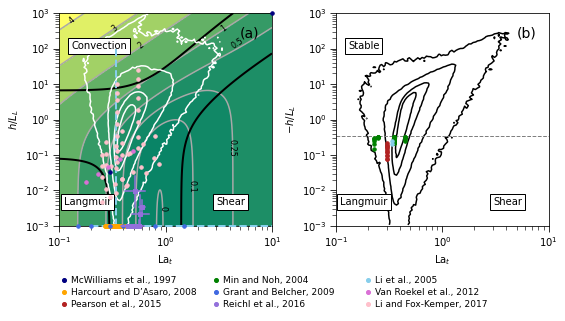

In [15]:
# Figure: regime diagram following Belcher et al., 2012

fig, axarr = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# plot regime diagram with pdf overlaid
plot_regime_diagram_BG12(hist_s1, xi_s1, yi_s1, axis=axarr[0])
    
axarr[0].text(5, 2e2, '(a)', fontsize=14, color='black')
axarr[0].tick_params(axis='both', which='major', length=6)
axarr[0].tick_params(axis='both', which='minor', length=4)

# plot bi-dimensional histogram
plot_regime_diagram_heating(hist_s2, xi_s2, yi_s2, axis=axarr[1])
axarr[1].text(5, 2e2, '(b)', fontsize=14, color='black')
axarr[1].tick_params(axis='both', which='major', length=6)
axarr[1].tick_params(axis='both', which='minor', length=4)

# y-shift of legend
yshift = -0.13

# Li and Fox-Kemper, 2017
add_scatter(lf17_la, lf17_hLL, color=c_lf17, axis=axarr[0])

# McWilliams et al., 1997
add_scatter(msm97_la, msm97_hLL, color=c_msm97, axis=axarr[0])

# Min and Noh, 2004
add_scatter(mn04_la, mn04_hLL, color=c_mn04, axis=axarr[1]) # heating

# Li et al., 2005
add_range(l05_la_range_s1, [l05_hLL_s1, l05_hLL_s1], color=c_l05, axis=axarr[0])
add_range([l05_la_s2, l05_la_s2], l05_hLL_range_s2, color=c_l05, axis=axarr[0])
add_scatter(l05_la_s3, l05_hLL_s3, color=c_l05, axis=axarr[1])

# Harcourt and D'Asaro, 2008
add_scatter(hd08_la_s1, hd08_hLL_s1, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s2, hd08_hLL_s2, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s3, hd08_hLL_s3, color=c_hd08, axis=axarr[0])
add_scatter(hd08_la_s4, hd08_hLL_s4, color=c_hd08, axis=axarr[0])

# Grant and Belcher, 2009
add_scatter(gb09_la, gb09_hLL, color=c_gb09, axis=axarr[0])

# Van Roekel et al., 2012
add_scatter(vr12_la, vr12_hLL, color=c_vr12, axis=axarr[0])

# Pearson et al., 2015
add_scatter(p15_la_s1, p15_hLL_s1, color=c_p15, axis=axarr[1]) # heating
add_scatter(p15_la_s2, p15_hLL_s2, color=c_p15, axis=axarr[1]) # heating

# Reichl et al., 2016
r16_la_s1_m = 10**r16_la_s1_mean
r16_la_s1_min = 10**(r16_la_s1_mean-r16_la_s1_std)
r16_la_s1_max = 10**(r16_la_s1_mean+r16_la_s1_std)
r16_hLL_s1_m = 10**r16_hLL_s1_mean
r16_hLL_s1_min = 10**(r16_hLL_s1_mean-r16_hLL_s1_std)
r16_hLL_s1_max = 10**(r16_hLL_s1_mean+r16_hLL_s1_std)
add_mean_and_range(r16_la_s1_m, r16_la_s1_min, r16_la_s1_max,
                   r16_hLL_s1_m, r16_hLL_s1_min, r16_hLL_s1_max,
                   color=c_r16, axis=axarr[0])
r16_la_s2_m = 10**r16_la_s2_mean
r16_la_s2_min = 10**(r16_la_s2_mean-r16_la_s2_std)
r16_la_s2_max = 10**(r16_la_s2_mean+r16_la_s2_std)
r16_hLL_s2_m = 10**r16_hLL_s2_mean
r16_hLL_s2_min = 10**(r16_hLL_s2_mean-r16_hLL_s2_std)
r16_hLL_s2_max = 10**(r16_hLL_s2_mean+r16_hLL_s2_std)
add_mean_and_range(r16_la_s2_m, r16_la_s2_min, r16_la_s2_max,
                   r16_hLL_s2_m, r16_hLL_s2_min, r16_hLL_s2_max,
                   color=c_r16, axis=axarr[0])

axarr[1].plot([1e-1, 1e1], [1/3, 1/3], '--', color='gray', linewidth=1)

# reduce margin
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.96, wspace=0.3, hspace=0.1)

# plot legend
# x- and y-labels
ax = fig.add_axes([0.1,0.05,0.8,0.1])
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
x_c1 = 0.01
x_c2 = 0.34
x_c3 = 0.67
y_r1 = 0.83
y_r2 = 0.5
y_r3 = 0.17
add_legend(ax, x_c1, y_r1, c_msm97, 'McWilliams et al., 1997')
add_legend(ax, x_c2, y_r1, c_mn04,  'Min and Noh, 2004')
add_legend(ax, x_c3, y_r1, c_l05,   'Li et al., 2005')
add_legend(ax, x_c1, y_r2, c_hd08,  'Harcourt and D’Asaro, 2008')
add_legend(ax, x_c2, y_r2, c_gb09,  'Grant and Belcher, 2009')
add_legend(ax, x_c3, y_r2, c_vr12,  'Van Roekel et al., 2012')
add_legend(ax, x_c1, y_r3, c_p15,   'Pearson et al., 2015')
add_legend(ax, x_c2, y_r3, c_r16,   'Reichl et al., 2016')
add_legend(ax, x_c3, y_r3, c_lf17,  'Li and Fox-Kemper, 2017')

# save figure
figname = 'fig_regime_diagram_LRF19.png'
plt.savefig(figname, dpi = 300)